# Plotting

In [1]:
# Import the modules and set the matplotlib style
import hep_spt
hep_spt.set_style()
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

## Plotting a (non)weighted sample
Use the function "errorbar_hist" to plot the same sample without and with weights. In the non-weighted case, the errors are considered poissonian, so one can see asymmetric error bars for low values of the number of entries.

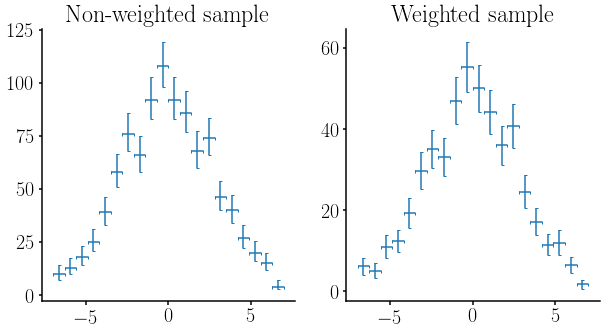

In [2]:
# Create a random sample
size = 1000
smp  = np.random.normal(0, 3, size)
wgts = np.random.uniform(0, 1, size)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

# Make the non-weighted plot
values, edges, ex, ey = hep_spt.errorbar_hist(smp, rg=(-7, 7))
centers = (edges[1:] + edges[:-1])/2.

ax0.errorbar(centers, values, ey, ex, ls='none')
ax0.set_title('Non-weighted sample')

# Make the weighted plot
values, edges, ex, ey = hep_spt.errorbar_hist(smp, rg=(-7, 7), wgts=wgts)
centers = (edges[1:] + edges[:-1])/2.

ax1.errorbar(centers, values, ey, ex, ls='none')
ax1.set_title('Weighted sample');

## Calculating the pull of a distribution
Sometimes we want to calculate the distance in terms of standard deviations from a curve to our measurements. This example creates a random sample of events following a normal distribution and overlies it with the original curve. The pull plot is shown below.

/home/slimbook/repos/hep_spt/hep_spt/plotting.py:230: RuntimeWarning: divide by zero encountered in divide
  pull[up] /= el[up]
/home/slimbook/repos/hep_spt/hep_spt/plotting.py:236: RuntimeWarning: divide by zero encountered in divide
  perr_u[up] = (eu[up]/el[up])


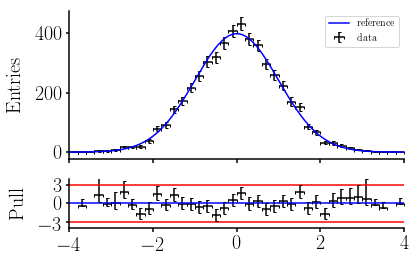

In [3]:
# Create the samples
size=5e3

sample = norm.rvs(size=int(size))

values, edges, ex, ey = hep_spt.errorbar_hist(sample, 40, rg=(-4, 4))
centers = (edges[1:] + edges[:-1])/2.

# Extract the PDF values in each center, and make the pull
ref  = norm.pdf(centers)
ref *= size/ref.sum()

pull, perr = hep_spt.pull(values, ey, ref)

# Make the reference to plot (with more points than just the centers of the bins)
rct, step = np.linspace(-4., 4., 1000, retstep=True)
pref = norm.pdf(rct)
pref = size*pref/pref.sum()*(edges[1] - edges[0])/step

fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]})

# Draw the histogram and the reference
ax0.errorbar(centers, values, ey, ex, color='k', ls='none', label='data')
ax0.plot(rct, pref, color='blue', marker='', label='reference')
ax0.set_xlim(-4., 4.)
ax0.set_ylabel('Entries')
ax0.legend()

# Draw the pull and lines for -3, 0 and +3 standard deviations
add_pull_line = lambda v, c: ax1.plot([-4., 4.], [v, v], color=c, marker='')

add_pull_line(0, 'blue')
add_pull_line(-3, 'red')
add_pull_line(+3, 'red')

ax1.errorbar(centers, pull, perr, ex, color='k', ls='none')
ax1.set_ylim(-4, 4)
ax1.set_yticks([-3, 0, 3])
ax1.set_ylabel('Pull');